# Step 0: Imports

In [1]:
# using tqdm.auto glitches out collaborative editing
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib as mpl
import matplotlib.pyplot as plt, mpld3

from math import sqrt
from collections import deque
import os
import random
from concurrent.futures import ProcessPoolExecutor
import pickle

torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == "cuda", "CUDA is not available. Please check your GPU setup."

In [2]:
# VTXS numbers here are inclusive
MIN_VTXS = 3
MAX_VTXS = 15
MAX_TUNE_VTXS = 7
AVG_DEG = 2
SEQ_LEN = MAX_VTXS + 1 # means 32 edges, final token is the target vertex
PAD_TOKEN = 0
EPOCH_SIZE = 2**20
# vertices are labelled 1,2,...,MAX_VTXS
# we also have a padding token which is 0.

# Step 1: Generate synthetic data

In [3]:
# original task data
# the data will be edge lists
# like this: [1 3 1 5 2 4 0 0 0 0 2]
# this represents edges (1,3), (1,5) (2,4)
# (the zeros are just padding tokens)
# the final 2 means which vertex we're going to 

# the label is the shortest distance from vtx 1 to vtx 2
# or "number of vertices" if no path exists

def random_graph(n):
    edge_list = []
    adjacencies = [set() for _ in range(n+1)]
    indices = [random.randint(1, n) for _ in range(AVG_DEG * n)]
    for i in range(0, len(indices), 2):
        u = indices[i]
        v = indices[i + 1]
        if u != v:
            if u < v:
                edge_list += [u, v]
            else:
                edge_list += [v, u]
            adjacencies[u].add(v)
            adjacencies[v].add(u)
    edge_list += [PAD_TOKEN]*(2*SEQ_LEN-1-len(edge_list))
    return edge_list, adjacencies

def SSSP(G, target=2, distonly=True):
    dist = [MAX_VTXS] * len(G)
    parent = [-1] * len(G)
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == MAX_VTXS:
                parent[x] = vtx
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    if distonly:
                        return dist[x]
                    path = [x]
                    while parent[x] != -1:
                        x = parent[x]
                        path.append(x)
                    return list(reversed(path))
    return MAX_VTXS if distonly else []

# large: size up to MAX_VTXS instead of MAX_TUNE_VTXS
# target: 2, "onpath", "any"
# largetarget: whether can go up to MAX_VTXS or just MAX_TUNE_VTXS
def mkbatch(size, large=True, target=2, largetarget=True):
    graphs = []
    dists = []
    
    for i in range(size):
        n = random.randint(MIN_VTXS, MAX_VTXS if large else MAX_TUNE_VTXS)
        while True:
            edge_list, adj_list = random_graph(n)
            if target == 2:
                # Train data
                dist = SSSP(adj_list)
                # Filter out some short distance graphs
                if 6 <= dist < MAX_VTXS or (dist < 6 and 2 * random.random() < 1 / (6 - dist)) or (dist == MAX_VTXS and random.random() < 1 / MAX_VTXS):
                    edge_list[-1] = 2
                    break
            elif target == "onpath":
                path = SSSP(adj_list, 2, False)
                dist = len(path) - 1
                # Filter out some short distance graphs
                if dist < 1 or (not large and dist < 4 and 3 * random.random() > 1 / (4 - dist)):
                    continue
                dist = random.choices(range(1, len(path)), weights=range(1, len(path)))[0]
                if (largetarget or path[dist] <= MAX_TUNE_VTXS):
                    edge_list[-1] = path[dist]
                    break
            elif target == "any":
                edge_list[-1] = random.randint(2, MAX_VTXS if largetarget else MAX_TUNE_VTXS)
                dist = SSSP(adj_list, edge_list[-1])
                break
        graphs.append(edge_list)
        dists.append(dist)
    
    data = torch.tensor(graphs)
    labels = torch.tensor(dists, dtype=torch.float32)
    padding = data == PAD_TOKEN
    return data, labels, padding

def savebatch(size, idx):
    data, labels, padding = mkbatch(size)
    everything = {
        "data": data,
        "labels": labels,
        "padding": padding,
    }
    
    with open(f'data-new/{idx}.pickle', 'wb') as file:
        pickle.dump(everything, file)

In [4]:
# Only need to run this once to generate training data
# RESTART THE KERNEL BEFORE RUNNING AND ONLY RUN THE CELLS ABOVE
# Python is slow and awful

# with ProcessPoolExecutor() as executor:
#     for i in range(64):
#         executor.submit(savebatch, EPOCH_SIZE, i)
#     executor.shutdown()

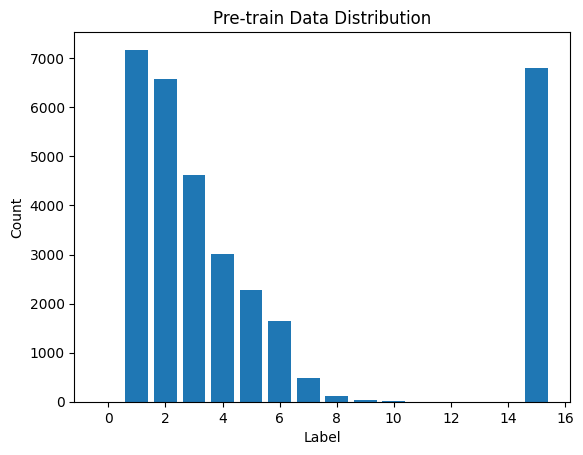

In [5]:
bins = torch.bincount(mkbatch(2**15)[1].to(torch.uint8).cpu())
plt.bar(range(len(bins)), bins)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Pre-train Data Distribution")
with open("plots/train-dist.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

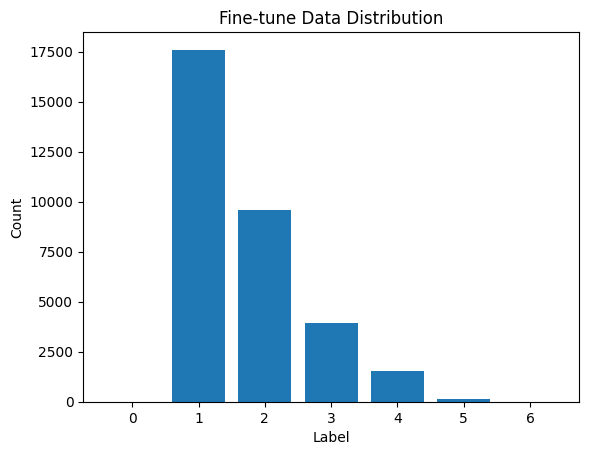

In [6]:
bins = torch.bincount(mkbatch(2**15, large=False, target="onpath")[1].to(torch.uint8).cpu())
plt.bar(range(len(bins)), bins)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Fine-tune Data Distribution")
with open("plots/tune-dist.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

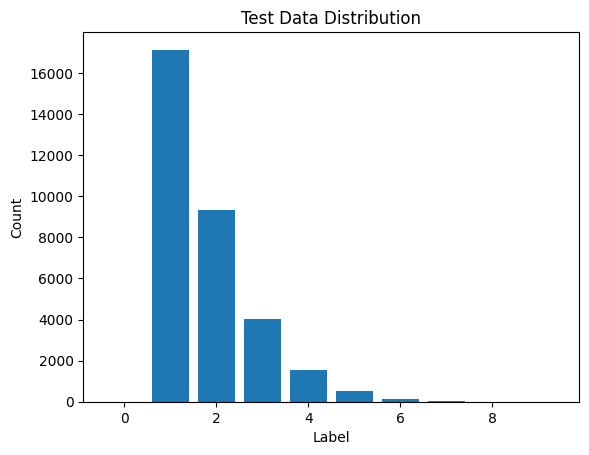

In [7]:
bins = torch.bincount(mkbatch(2**15, large=True, target="onpath", largetarget=False)[1].to(torch.uint8).cpu())
plt.bar(range(len(bins)), bins)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Test Data Distribution")
with open("plots/test-dist.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

# Step 2: Define Transformer Model

In [4]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, output_dim, num_heads, num_layers, seq_len, dropout):
        super().__init__()
        self.model_dim = model_dim
        self.embedding = nn.Embedding(input_dim, model_dim // 2)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads,
                                                   dim_feedforward=model_dim*4,
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(model_dim, output_dim)

    def forward(self, src, key_padding_mask):
        batch_sz = src.size(0)
        src = torch.cat((src, torch.full((batch_sz, 1), MAX_VTXS + 1, device=device)), dim=1)
        embed = torch.cat((self.embedding(src[:,::2]), self.embedding(src[:,1::2])), dim=2)
        output = self.transformer_encoder(embed, src_key_padding_mask=key_padding_mask[:, ::2])
        return self.fc_out(output[:, -1, :])

# Step 3: Make Model

In [5]:
# PARAMS
VOCAB_SIZE = 1 + MAX_VTXS + 1 # pad plus max number of vertices plus target token
MODEL_DIM = 64 # Dimension of model (embedding and transformer)
NEPOCHS = 100
BSZ = 2**15 # Batch size
NHEADS = 2
NLAYERS = 6
DROPOUT = 0 # 0.2
model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
                         output_dim=1, num_heads=NHEADS,
                         num_layers=NLAYERS, seq_len=SEQ_LEN,
                         dropout=DROPOUT).to(device)
model = torch.compile(model)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Training data: {NEPOCHS*EPOCH_SIZE//10**3}K")
print(f"Trainable parameters in the model: {trainable_params}")

train_err = []
len1 = []
len2 = []
len3 = []
leninf = []
epoch = 0

# clear loss file
open('loss', 'w').close()

Training data: 104857K
Trainable parameters in the model: 300513


In [7]:
# model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
#                          output_dim=1, num_heads=NHEADS,
#                          num_layers=NLAYERS, seq_len=SEQ_LEN,
#                          dropout=DROPOUT).to(device)
# model = torch.compile(model)
# model.load_state_dict(torch.load('model.pth', weights_only=True))

LR = 1e-3

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Step 4: Train the Model for the first task

In [8]:
while epoch < NEPOCHS:
    model.train()
    with open(f"data-new/{epoch}.pickle", "rb") as f:
        pickled_stuff = pickle.load(f)
    data = pickled_stuff["data"].to(device)
    label = pickled_stuff["labels"].to(device).to(torch.float32)
    padding = pickled_stuff["padding"].to(device)
    dataset = TensorDataset(data, label, padding)
    loader = DataLoader(dataset, batch_size=BSZ)
    for batch_src, batch_labels, batch_padding_mask in tqdm(loader):
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        loss.backward()
        optimizer.step()
        
        train_err.append(loss.item())
        len1.append(criterion(output[batch_labels == 1].squeeze(1), batch_labels[batch_labels == 1]).item())
        len2.append(criterion(output[batch_labels == 2].squeeze(1), batch_labels[batch_labels == 2]).item())
        len3.append(criterion(output[batch_labels == 3].squeeze(1), batch_labels[batch_labels == 3]).item())
        leninf.append(criterion(output[batch_labels == MAX_VTXS].squeeze(1), batch_labels[batch_labels == MAX_VTXS]).item())
        
        with open('loss', 'a') as f:
            f.write(f"{train_err[-1]} {len1[-1]} {len2[-1]} {len3[-1]} {leninf[-1]}\n")
    epoch_err = lambda l: sum(l[-EPOCH_SIZE // BSZ:]) / EPOCH_SIZE * BSZ
    print(f"Epoch {epoch}/{NEPOCHS} \t Train Err: {epoch_err(train_err)} {epoch_err(len1)} {epoch_err(len2)} {epoch_err(len3)} {epoch_err(leninf)}")

    epoch += 1
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"checkpoints/model_weights_{epoch}.pth")

/home/sipb/.venv/lib64/python3.12/site-packages/torch/nn/functional.py:6278: UserWarning: Memory Efficient attention on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:269.)
  attn_output = scaled_dot_product_attention(
/tmp/torchinductor_sipb/p5/cp5ogl77xlvv4lzubyvimmor72gh5qiymvzslhatxqlh2iskkcqu.py:1018: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  extern_kernels.mm(reinterpret_tensor(buf1, (524288, 64), (64, 1), 0), reinterpret_tensor(primals_5, (64, 192), (1, 64), 0), out=buf2)

00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 0/100 	 Train Err: 5.915580503642559 0.4505993718339596 0.6243474127259105 1.5954655343666673 22.043999701738358



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 1/100 	 Train Err: 0.6586012691259384 0.010000545691582374 0.024956375011242926 0.0908401117194444 2.200286313891411



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]

Epoch 2/100 	 Train Err: 0.2822786392644048 0.003877735580317676 0.011804497975390404 0.06714203883893788 0.6882269307971001



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.44it/s]

Epoch 3/100 	 Train Err: 0.19177303789183497 0.0033735682591213845 0.00941117930051405 0.06364660896360874 0.40807230956852436



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.43it/s]

Epoch 4/100 	 Train Err: 0.142419709591195 0.0026143487593799364 0.007357882786891423 0.058737545274198055 0.2563177370466292



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.44it/s]

Epoch 5/100 	 Train Err: 0.11377326445654035 0.002205640936153941 0.006019950611516833 0.0485867268871516 0.19204956525936723



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 6/100 	 Train Err: 0.09546203236095607 0.0019339443933859002 0.0052241795710870065 0.042339954525232315 0.14500665361993015



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 7/100 	 Train Err: 0.08380867214873433 0.0025053542904061032 0.0052922226750524715 0.03802183154039085 0.11907450819853693



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:21<00:00,  1.46it/s]

Epoch 8/100 	 Train Err: 0.07723104278557003 0.0029060271444905084 0.0059348611466703005 0.03568730264669284 0.10317586152814329



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 9/100 	 Train Err: 0.06973861914593726 0.0020777636782440823 0.004200900097202975 0.032207064679823816 0.08401392458472401



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:21<00:00,  1.47it/s]

Epoch 10/100 	 Train Err: 0.06660757877398282 0.002029255470915814 0.004411700545460917 0.03103881428251043 0.08006043778732419



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 11/100 	 Train Err: 0.0638601048849523 0.0019552546054910636 0.004216364446619991 0.030923083191737533 0.06965454539749771



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 12/100 	 Train Err: 0.06380962789990008 0.004082398601894965 0.005662415154802147 0.030096195463556796 0.06712937023257837



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.44it/s]

Epoch 13/100 	 Train Err: 0.05648710671812296 0.0015669492140659713 0.003465047884674277 0.027280425652861595 0.0580466557003092



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.44it/s]

Epoch 14/100 	 Train Err: 0.05479328567162156 0.002785868946375558 0.004651390452636406 0.02628502214793116 0.05516616065870039



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.44it/s]

Epoch 15/100 	 Train Err: 0.05039948446210474 0.001386107914186141 0.002831360572599806 0.023484625620767474 0.04737765033496544



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 16/100 	 Train Err: 0.0479898703051731 0.001850387139711529 0.0033599310663703363 0.02412145968992263 0.04099923963076435



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:21<00:00,  1.46it/s]

Epoch 17/100 	 Train Err: 0.04865480866283178 0.002051993552413478 0.0033408473536837846 0.022620209609158337 0.04534965530910995



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.44it/s]

Epoch 18/100 	 Train Err: 0.046673479839228094 0.003542559619745589 0.0036264514783397317 0.02171917725354433 0.040135253919288516



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.44it/s]

Epoch 19/100 	 Train Err: 0.04334549431223422 0.002015004936765763 0.002814352781570051 0.020710892393253744 0.03765762131661177



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.44it/s]

Epoch 20/100 	 Train Err: 0.04148448130581528 0.0012918650036226609 0.002228728772024624 0.019462902564555407 0.034912509290734306



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.43it/s]

Epoch 21/100 	 Train Err: 0.04145978135056794 0.001451208453545405 0.0021605480651487596 0.01913026621332392 0.0369064172700746



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.43it/s]

Epoch 22/100 	 Train Err: 0.041122547117993236 0.0014523757236020174 0.0023905441848910414 0.01923307462129742 0.03851280417438829



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]

Epoch 23/100 	 Train Err: 0.03945205733180046 0.0019882373744621873 0.0024855316842149477 0.018886710691731423 0.03429982590023428



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.43it/s]

Epoch 24/100 	 Train Err: 0.03960938355885446 0.0014295643559307791 0.001973358819668647 0.018016513844486326 0.033691041855490766



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.41it/s]

Epoch 25/100 	 Train Err: 0.03732225619023666 0.0008848551324263099 0.0016024388787627686 0.0176690933003556 0.027674593147821724



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.43it/s]

Epoch 26/100 	 Train Err: 0.03627042338484898 0.001499695326856454 0.002097381031489931 0.01686566128046252 0.028806022281059995



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.44it/s]

Epoch 27/100 	 Train Err: 0.035848396830260754 0.001287375605897978 0.0019127794657833874 0.01593246089760214 0.026827875160961412



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 28/100 	 Train Err: 0.03657312598079443 0.0015639464845662587 0.0020721888595289784 0.016167674533789977 0.02817649155986146



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.41it/s]

Epoch 29/100 	 Train Err: 0.03576729737687856 0.0020534898562800663 0.0024041683045652462 0.01594006348750554 0.026180977536569117



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 30/100 	 Train Err: 0.035552564600948244 0.0014864003778711776 0.0017050756123353494 0.016300543153192848 0.02777327578223776



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]

Epoch 31/100 	 Train Err: 0.03428351623006165 0.001444402550077939 0.0018266159950144356 0.015063455561175942 0.02663210871105548



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.44it/s]

Epoch 32/100 	 Train Err: 0.03501159755978733 0.002936632603450562 0.002198894866523915 0.015069253509864211 0.02531576040200889



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.43it/s]

Epoch 33/100 	 Train Err: 0.03346483368659392 0.001996557608435978 0.0022031095359125175 0.014728363748872653 0.025125903215666767



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]

Epoch 34/100 	 Train Err: 0.031978628889191896 0.0017423779681848828 0.002208279212936759 0.014501040190225467 0.02167539324000245



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 35/100 	 Train Err: 0.030237189552281052 0.0009807684709812747 0.001220987909618998 0.013532102369936183 0.021276738145388663



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 36/100 	 Train Err: 0.03018926049116999 0.001993048860640556 0.002174867033318151 0.013142088806489483 0.020710692788270535



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 37/100 	 Train Err: 0.03291426139185205 0.0016913060171646066 0.0018038520101981703 0.013622223661513999 0.025715603376738727



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 38/100 	 Train Err: 0.03292314306600019 0.001423079178948683 0.0018923715779237682 0.013977676921058446 0.02660236544215877



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 39/100 	 Train Err: 0.03366135340183973 0.003713737090492941 0.0032114218010974582 0.013475002051563933 0.022797897072450723



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]

Epoch 40/100 	 Train Err: 0.0302321165218018 0.0018661972703739593 0.002139017402441823 0.012839974806411192 0.02126855951064499



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]

Epoch 41/100 	 Train Err: 0.03136210091179237 0.0017414160747648566 0.0018688730087887961 0.012817082926630974 0.021657537272403715



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.43it/s]

Epoch 42/100 	 Train Err: 0.028969725884962827 0.0014723996041539067 0.0017433645134588005 0.01163470497704111 0.020261481789930258



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]

Epoch 43/100 	 Train Err: 0.02993922942550853 0.0015754283244859835 0.0016384204300265992 0.01222276160842739 0.02234961706381



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.43it/s]

Epoch 44/100 	 Train Err: 0.0286809160024859 0.0013326343182598066 0.0013536325423046947 0.011975903384154662 0.016841779468450113



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]

Epoch 45/100 	 Train Err: 0.03139403503155336 0.0035768008974628174 0.0029325948753466946 0.012497565156081691 0.020677608052210417



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.44it/s]

Epoch 46/100 	 Train Err: 0.03304112673504278 0.0030878368820594915 0.0026825040731637273 0.013036122400080785 0.02266561113356147



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 47/100 	 Train Err: 0.036241460358724 0.003998833924924838 0.0027683060870913323 0.013322437211172655 0.02949316889498732



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.41it/s]

Epoch 48/100 	 Train Err: 0.02795609034365043 0.0010915815259977535 0.0010533893137107952 0.010564433294348419 0.0179318796726875



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.43it/s]

Epoch 49/100 	 Train Err: 0.02986836590571329 0.001193666770177515 0.001290240723392344 0.01145344074757304 0.0236946784571046



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.44it/s]

Epoch 50/100 	 Train Err: 0.03164456982631236 0.0013313994736563473 0.0017484278478150372 0.012924699374707416 0.02163192303123651



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 51/100 	 Train Err: 0.030807556468062103 0.0020667458511525183 0.0019197424235244398 0.01282453999738209 0.019454967376077548



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]

Epoch 52/100 	 Train Err: 0.029965722118504345 0.0012791909425686754 0.001596282026184781 0.012344098096946254 0.01784065420361003



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.41it/s]

Epoch 53/100 	 Train Err: 0.0265352891292423 0.0007964646529217134 0.000907563671717071 0.010262767085805535 0.01773800441151252



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 54/100 	 Train Err: 0.02751670015277341 0.0016817037853797956 0.0014505806020679302 0.009788958472199738 0.020279350777855143



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]

Epoch 55/100 	 Train Err: 0.025883044116199017 0.001346661450497777 0.0012914722201458062 0.009638282572268508 0.016253164734735037



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]

Epoch 56/100 	 Train Err: 0.022739437001291662 0.0008026059808798891 0.0008494512694596779 0.008352860197192058 0.010978442945997813



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]

Epoch 57/100 	 Train Err: 0.022440483327955008 0.0009071951262740185 0.000916149912882247 0.00847361990599893 0.011131145221952465



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.44it/s]

Epoch 58/100 	 Train Err: 0.025345811736769974 0.0013864098896192445 0.0009498761282884516 0.008939172679674812 0.018441449870806537



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.43it/s]

Epoch 59/100 	 Train Err: 0.023891851538792253 0.0012925871601510153 0.0011148671910632402 0.008856966407620348 0.012021984035527566



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.44it/s]

Epoch 60/100 	 Train Err: 0.02362089912639931 0.000830721450256533 0.0009114332578974427 0.008526757796062157 0.015250902635671082



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]

Epoch 61/100 	 Train Err: 0.02107378770597279 0.0006254979271034244 0.0005897696282772813 0.007054049608996138 0.01111846130243066



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 62/100 	 Train Err: 0.022748558258172125 0.0010031351662291854 0.0010334590497222962 0.008041846929700114 0.01214356779382797



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.41it/s]

Epoch 63/100 	 Train Err: 0.022991930542048067 0.0017326328943454428 0.0016703186793165514 0.0084057802305324 0.012902150609988894



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.41it/s]

Epoch 64/100 	 Train Err: 0.02534142223885283 0.0012205752486806887 0.0015509294298681198 0.008817054331302643 0.013319303647222114



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]

Epoch 65/100 	 Train Err: 0.02489184361184016 0.0026096420592693903 0.0020677366856034496 0.008033131685806438 0.01523421258025337



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]

Epoch 66/100 	 Train Err: 0.023243437928613275 0.0012699099929704971 0.001188018263746926 0.008441859725280665 0.012707948594652407



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]

Epoch 67/100 	 Train Err: 0.02045453805476427 0.0009292269828620192 0.0007864252675062744 0.00639261981996242 0.010473506097696372



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.43it/s]

Epoch 68/100 	 Train Err: 0.023632179712876678 0.0013570280530075252 0.0011699169172061374 0.007411329337628558 0.01571820306344307



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.40it/s]

Epoch 69/100 	 Train Err: 0.028572456794790924 0.0024852919050317723 0.0016593521968388814 0.008402477891650051 0.019322560167893243



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:21<00:00,  1.46it/s]

Epoch 70/100 	 Train Err: 0.02618635556427762 0.0010985648273162951 0.0009723617358758929 0.00780354329617694 0.019848162693961058



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.44it/s]

Epoch 71/100 	 Train Err: 0.025947992515284568 0.0009713285044199438 0.0008430656744167209 0.00737694461713545 0.017320051238129963



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]

Epoch 72/100 	 Train Err: 0.021004761045332998 0.0008035176952034817 0.0007906993705546483 0.0062158213258953765 0.01110647956329558



16%|███████████████████████████████▎                                                                                                                                                                        | 5/32 [00:04<00:22,  1.19it/s]

KeyboardInterrupt: 

In [9]:
def evaluate(data):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), data)
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return output.detach(), batch_labels.detach().to(torch.uint8), loss.item()

def mkhist(data, title):
    y, x, loss = evaluate(data)
    print(loss)
    cnts = torch.bincount(x)
    weights = [1/cnts[i.item()].item() for i in x] # normalize by label count
    fig, ax = plt.subplots()
    h = ax.hist2d(x.cpu().numpy().flatten(), y.cpu().numpy().flatten(), weights=weights, bins=[cnts.shape[0] - 1, 50], norm=mpl.colors.LogNorm())
    ax.set_xlabel("Label")
    ax.set_ylabel("Model Output")
    ax.set_title(title)
    fig.colorbar(h[3], ax=ax)
    return fig

In [10]:
evaluate(mkbatch(BSZ))[2]

0.018195968121290207

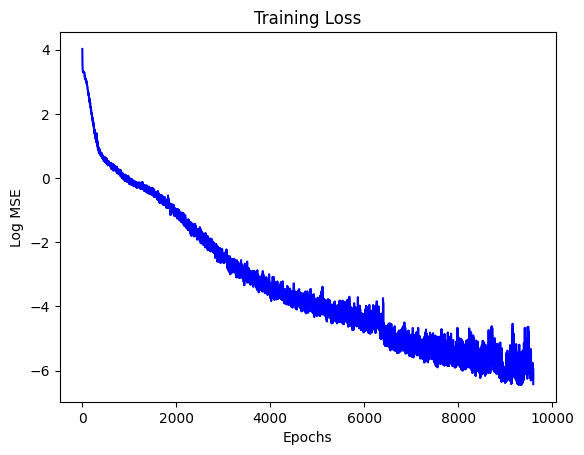

In [49]:
with open('loss') as f:
    losses = torch.tensor([list(map(float, l.split())) for l in f.readlines()])
plt.plot(torch.log(losses[:, 0]), label='Train', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Log MSE')
plt.title('Training Loss')
with open("plots/train-loss.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

0.002062194049358368


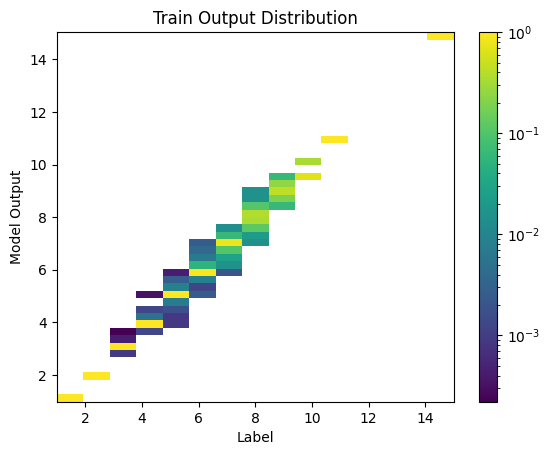

In [116]:
fig = mkhist(mkbatch(BSZ), "Train Output Distribution")
with open("plots/train-hist.html", "w") as f:
    mpld3.save_html(fig, f)

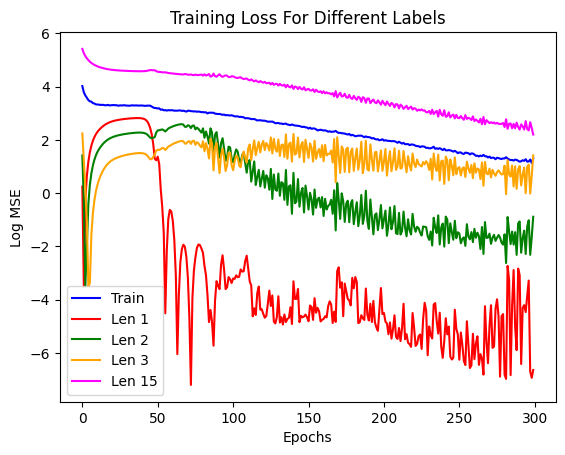

In [50]:
plt.plot(torch.log(losses[:300, 0]), label='Train', color='blue')
plt.plot(torch.log(losses[:300, 1]), label='Len 1', color='red')
plt.plot(torch.log(losses[:300, 2]), label='Len 2', color='green')
plt.plot(torch.log(losses[:300, 3]), label='Len 3', color='orange')
plt.plot(torch.log(losses[:300, 4]), label='Len 15', color='magenta')
plt.xlabel('Epochs')
plt.ylabel('Log MSE')
plt.title('Training Loss For Different Labels')
plt.legend()
with open("plots/train-lens.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

In [180]:
# Testing line graph
inp = torch.cat((torch.repeat_interleave(torch.arange(2, MAX_VTXS + 1), 2)[1:-1], torch.tensor([1, 15, 0, 0, 2]))).unsqueeze(0).to(device)
print(inp)
model(inp, inp == PAD_TOKEN)

tensor([[ 2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9, 10, 10, 11,
         11, 12, 12, 13, 13, 14, 14, 15,  1, 15,  0,  0,  2]], device='cuda:0')


tensor([[7.1840]], device='cuda:0', grad_fn=<CompiledFunctionBackward>)

# Step 5: Fine Tune

In [12]:
N_TUNE_EPOCHS = 50
TUNE_LR = 1e-5
TUNE_WD = 0

tune_criterion = nn.MSELoss()
tune_optimizer = torch.optim.Adam(model.parameters(), lr=TUNE_LR, weight_decay=TUNE_WD)

tune_train_err = []
epoch = 0

# clear loss file
open('tune_loss', 'w').close()

In [13]:
while epoch < N_TUNE_EPOCHS:
    model.train()
    train_loss = 0
    batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mkbatch(BSZ, large=False, target="onpath"))
    optimizer.zero_grad()
    output = model(batch_src, batch_padding_mask)
    loss = criterion(output.squeeze(1), batch_labels)
    train_loss = loss.item()
    loss.backward()
    optimizer.step()
    
    tune_train_err.append(train_loss)
    with open('tune_loss', 'a') as f:
        f.write(f"{train_loss}\n")
    print(f"Epoch {epoch}/{N_TUNE_EPOCHS} \t Train Err: {train_loss}")

    if epoch % 10 == 9:
        torch.save(model.state_dict(), f"checkpoints/tune_model_weights_{epoch + 1}.pth")
    epoch += 1

Epoch 0/50 	 Train Err: 0.5752755403518677
Epoch 1/50 	 Train Err: 1.0058379173278809
Epoch 2/50 	 Train Err: 1.1355644464492798
Epoch 3/50 	 Train Err: 0.4999964237213135
Epoch 4/50 	 Train Err: 0.5071491599082947
Epoch 5/50 	 Train Err: 0.4544726014137268
Epoch 6/50 	 Train Err: 0.30281758308410645
Epoch 7/50 	 Train Err: 0.4206203818321228
Epoch 8/50 	 Train Err: 0.7253834009170532
Epoch 9/50 	 Train Err: 0.5732952356338501
Epoch 10/50 	 Train Err: 0.3130272626876831
Epoch 11/50 	 Train Err: 0.5048601627349854
Epoch 12/50 	 Train Err: 0.22613315284252167
Epoch 13/50 	 Train Err: 0.4204784035682678
Epoch 14/50 	 Train Err: 0.16267633438110352
Epoch 15/50 	 Train Err: 0.2796379625797272
Epoch 16/50 	 Train Err: 0.32184848189353943
Epoch 17/50 	 Train Err: 0.14892461895942688
Epoch 18/50 	 Train Err: 0.18450167775154114
Epoch 19/50 	 Train Err: 0.1992523968219757
Epoch 20/50 	 Train Err: 0.17124706506729126
Epoch 21/50 	 Train Err: 0.14664874970912933
Epoch 22/50 	 Train Err: 0.1372433

In [14]:
evaluate(mkbatch(BSZ, large=False, target="onpath"))[2]

0.02088712900876999

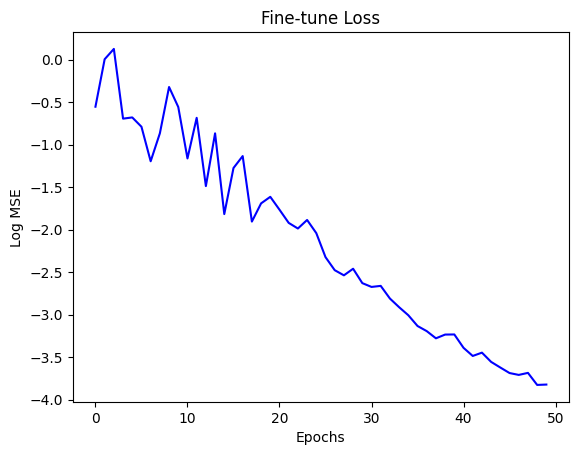

In [15]:
plt.plot(torch.log(torch.tensor(tune_train_err)), label="Train", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Log MSE")
plt.title("Fine-tune Loss")
with open("plots/tune-loss.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

0.021510595455765724


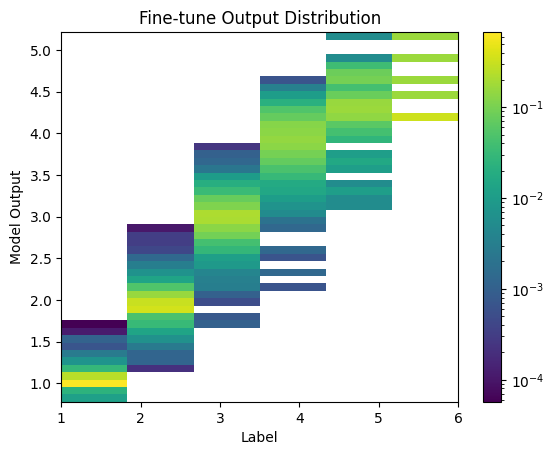

In [16]:
mkhist(mkbatch(BSZ, large=False, target="onpath"), "Fine-tune Output Distribution")
with open("plots/tune-hist.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

# Step 6: Test generalization

0.26651668548583984


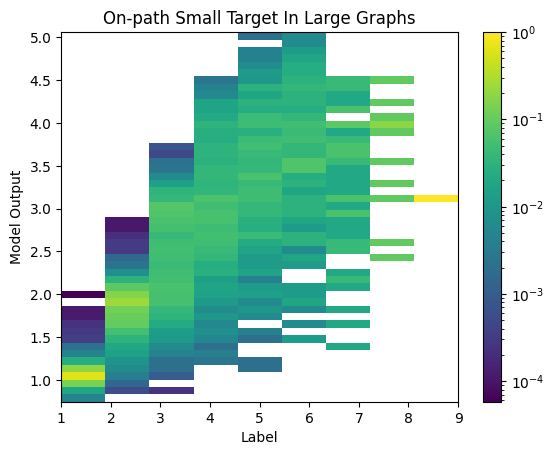

In [17]:
mkhist(mkbatch(BSZ, large=True, target="onpath", largetarget=False), "On-path Small Target In Large Graphs")
with open("plots/test-onpath-smalltarget.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

0.27889782190322876


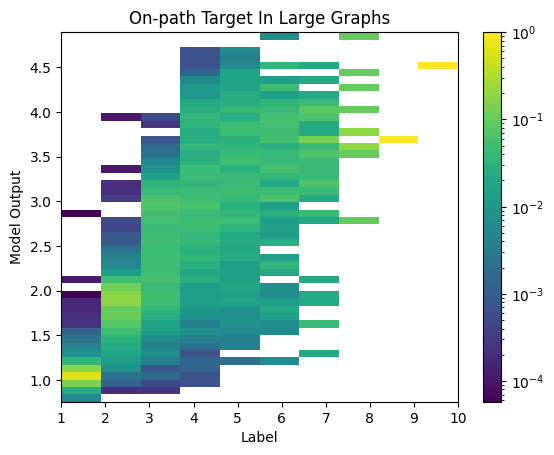

In [18]:
mkhist(mkbatch(BSZ, large=True, target="onpath", largetarget=True), "On-path Target In Large Graphs")
with open("plots/test-onpath-largetarget.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

62.716026306152344


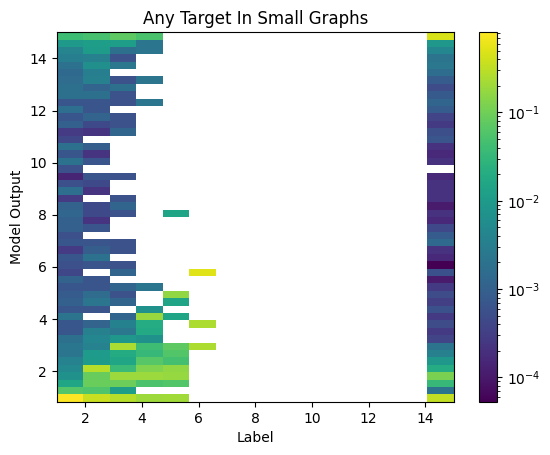

In [39]:
mkhist(mkbatch(BSZ, large=False, target="any", largetarget=False), "Any Target In Small Graphs")
with open("plots/test-small-any.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

47.901283264160156


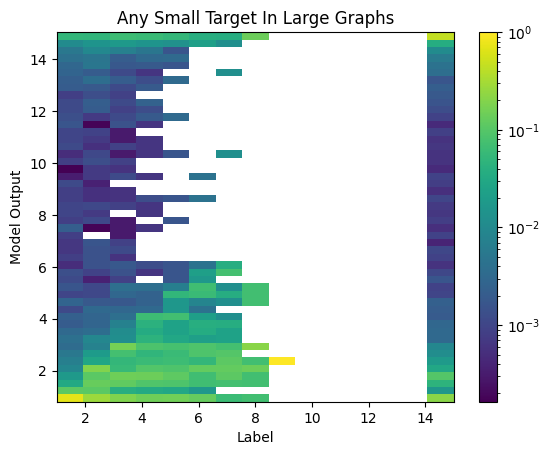

In [40]:
mkhist(mkbatch(BSZ, large=True, target="any", largetarget=False), "Any Small Target In Large Graphs")
with open("plots/test-large-any-smalltarget.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

71.74824523925781


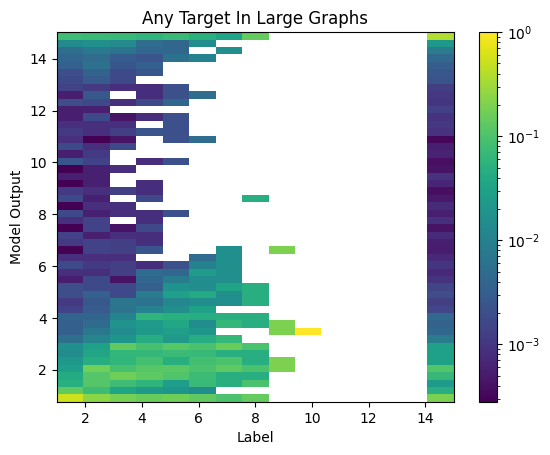

In [41]:
mkhist(mkbatch(BSZ, large=True, target="any", largetarget=True), "Any Target In Large Graphs")
with open("plots/test-large-any-largetarget.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)